<a href="https://colab.research.google.com/github/yeonsub/models_from_scratch/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch
import numpy as np
import random

def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(16)

CNN을 이용해서 MNIST 이미지를 학습해 보겠습니다.

In [12]:
import torchvision.datasets as datasets


mnist_train = datasets.MNIST(root='MNIST_data/',
                          train=True,
                          download=True)

mnist_test = datasets.MNIST(root='MNIST_data/',
                         train=False,
                         download=True)

In [13]:
from torch.utils.data import Dataset, DataLoader


class mnist_dataset(Dataset):
    def __init__(self, data):
        super(mnist_dataset, self).__init__()
        self.images = data.data
        self.labels = data.targets

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return {
            "images": self.images[idx].unsqueeze(axis=0)/255,
            "labels": self.labels[idx]
        }

train_dataset = mnist_dataset(mnist_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = mnist_dataset(mnist_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


모델의 파라미터를 직접 수정하면서 shape이 어떻게 변화하는지 확인해 보세요!

In [14]:
import torch
import torch.nn as nn


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)

        '''
        convolution layer의 구조를 수정할 경우, 아래 Linear 레이어의 input dimension을 바꿔줘야 합니다.
        잘 계산해서 convolution layer의 결과의 차원 수를 모두 곱해서 입력하면 됩니다.
        (현재는 self.pool2까지 수행한 결과가 [16, 7, 7] 형태이므로 7*7*16을 넣은 것.)
        '''
        self.dense = nn.Linear(7*7*16, 10)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        batch_size = inputs.shape[0]
        x = self.conv1(inputs)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = x.view(batch_size, -1)
        outputs = self.dense(x)

        return outputs

    def test_shape(self, input_shape=(16, 1, 28, 28)):
        dummy_inputs = torch.randn(input_shape)
        batch_size = input_shape[0]
        print("Input shape :", input_shape, "\n")
        with torch.no_grad():
            x = self.conv1(dummy_inputs)
            print(self.conv1)
            print("output shape :", x.shape, "\n")
            x = self.conv2(x)
            print(self.conv2)
            print("output shape :", x.shape, "\n")
            x = self.pool1(x)
            print(self.pool1)
            print("output shape :", x.shape, "\n")
            x = self.conv3(x)
            print(self.conv3)
            print("output shape :", x.shape, "\n")
            x = self.conv4(x)
            print(self.conv4)
            print("output shape :", x.shape, "\n")
            x = self.pool2(x)
            print(self.pool2)
            print("output shape :", x.shape, "\n")
            x = x.view(batch_size, -1)
            print("Reshape Tensor")
            print("output shape :", x.shape, "\n")
            outputs = self.dense(x)
            print(self.dense)
            print("output shape :", outputs.shape)

model = CNN()
model.test_shape()

Input shape : (16, 1, 28, 28) 

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
output shape : torch.Size([16, 32, 28, 28]) 

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
output shape : torch.Size([16, 32, 28, 28]) 

MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
output shape : torch.Size([16, 32, 14, 14]) 

Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
output shape : torch.Size([16, 16, 14, 14]) 

Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
output shape : torch.Size([16, 16, 14, 14]) 

MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
output shape : torch.Size([16, 16, 7, 7]) 

Reshape Tensor
output shape : torch.Size([16, 784]) 

Linear(in_features=784, out_features=10, bias=True)
output shape : torch.Size([16, 10])


In [15]:
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense): Linear(in_features=784, out_features=10, bias=True)
  (relu): ReLU()
)

In [26]:
from tqdm import tqdm

loss_track = []
epoch_loss = 0

for epoch in range(3):
    print("epoch :", epoch)
    model.train()
    train_loss = []
    for step, data in enumerate(tqdm(train_loader)):
        data = {k: v.to(device) for k, v in data.items()}
        images = data["images"].float()
        output = model(images)
        loss = criterion(output, data["labels"])
        train_loss.append(loss.detach().cpu().item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = sum(train_loss)/len(train_loss)
    loss_track.append(epoch_loss)
    print(f"{epoch} loss :", epoch_loss)


epoch : 0


100%|██████████| 3750/3750 [00:10<00:00, 348.38it/s]


0 loss : 0.026758549812162042
epoch : 1


100%|██████████| 3750/3750 [00:10<00:00, 352.08it/s]


1 loss : 0.022907172475984894
epoch : 2


100%|██████████| 3750/3750 [00:11<00:00, 316.44it/s]

2 loss : 0.019967043587629345


In [27]:
model.eval()
outputs = []
for data in tqdm(test_loader):
    data = {k: v.to(device) for k, v in data.items()}
    images = data["images"].float()
    with torch.no_grad():
      output = model(images)
    outputs.append(output.cpu())

outputs = torch.cat(outputs, dim=0)
preds = torch.argmax(outputs, dim=-1)
correct = (preds == mnist_test.targets).sum().item()/len(test_dataset)
print(f"model accuracy on test set : {correct*100}")

100%|██████████| 625/625 [00:00<00:00, 883.63it/s]


model accuracy on test set : 99.08


PyTorch의 모델 파라미터를 쉽게 확인할 수 있는 방법에 대해 소개드리겠습니다.

In [28]:
!pip install torchsummary

In [29]:
import torchsummary

torchsummary.summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]           9,248
              ReLU-4           [-1, 32, 28, 28]               0
         MaxPool2d-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 16, 14, 14]           4,624
              ReLU-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           2,320
              ReLU-9           [-1, 16, 14, 14]               0
        MaxPool2d-10             [-1, 16, 7, 7]               0
           Linear-11                   [-1, 10]           7,850
Total params: 24,362
Trainable params: 24,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [30]:
dense_model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)

torchsummary.summary(dense_model, (1, 28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


이렇게 확인해 보면, 기존의 dense model의 파라미터의 10분의 1만 사용하고도 CNN 모델의 성능이 더 좋은 것을 알 수 있습니다.

CNN의 또 다른 장점은, 모델이 이미지를 어떻게 인식하고 있는지를 시각화할 수 있다는 것입니다. 이는 모델의 성능에 대한 분석 수단으로도 활용이 가능합니다.

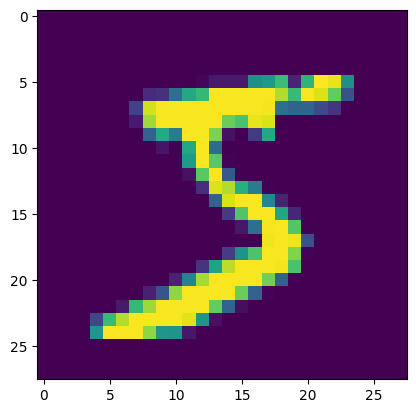

In [31]:
import matplotlib.pyplot as plt

sample = train_dataset[0]['images']

plt.imshow(sample.squeeze())

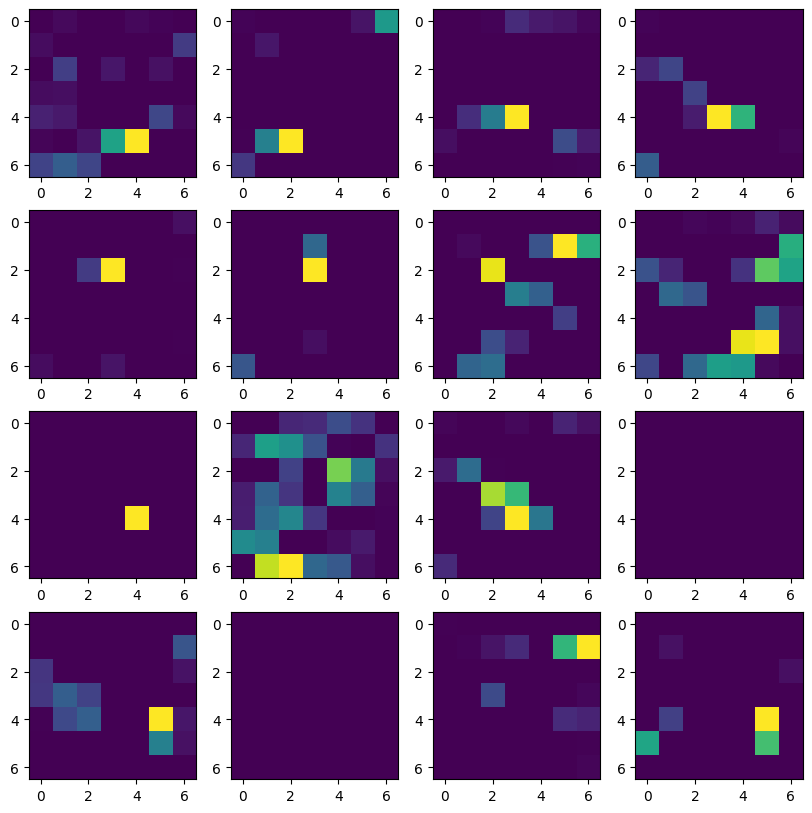

In [32]:
sample = train_dataset[0]['images']

with torch.no_grad():
    x = model.conv1(sample.to(device))
    x = model.relu(x)
    x = model.conv2(x)
    x = model.relu(x)
    x = model.pool1(x)
    x = model.conv3(x)
    x = model.relu(x)
    x = model.conv4(x)
    x = model.relu(x)
    x = model.pool2(x)

fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4*4):
    ax[i//4][i%4].imshow(x[i].cpu())